In [2]:
import numpy as np
import torch
from torch.distributions.normal import Normal

import pyro
import pyro.distributions as dist

from generation_with_evaluation_period import generative_procedure_with_evaluation_period, generative_procedure_future
from generation_with_evaluation_period import plot_time_series
import kalman_filter
from kalman_smoothing import kalman_smoothing
from fake_path_trick import fake_path_trick
from likelihood import log_likelihood

from change_point_and_anomaly import update_p_a_t, update_p_c_t
from change_point_and_anomaly import generate_z_a_t, generate_z_c_t
from change_point_and_anomaly import  segment_control

from update_params import update_sigma_e, update_sigma_o, update_sigma_u, update_sigma_r, update_sigma_delta, update_sigma_gamma



from likelihood import log_likelihood
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt

Text(0.5,1,'CPU Workload')

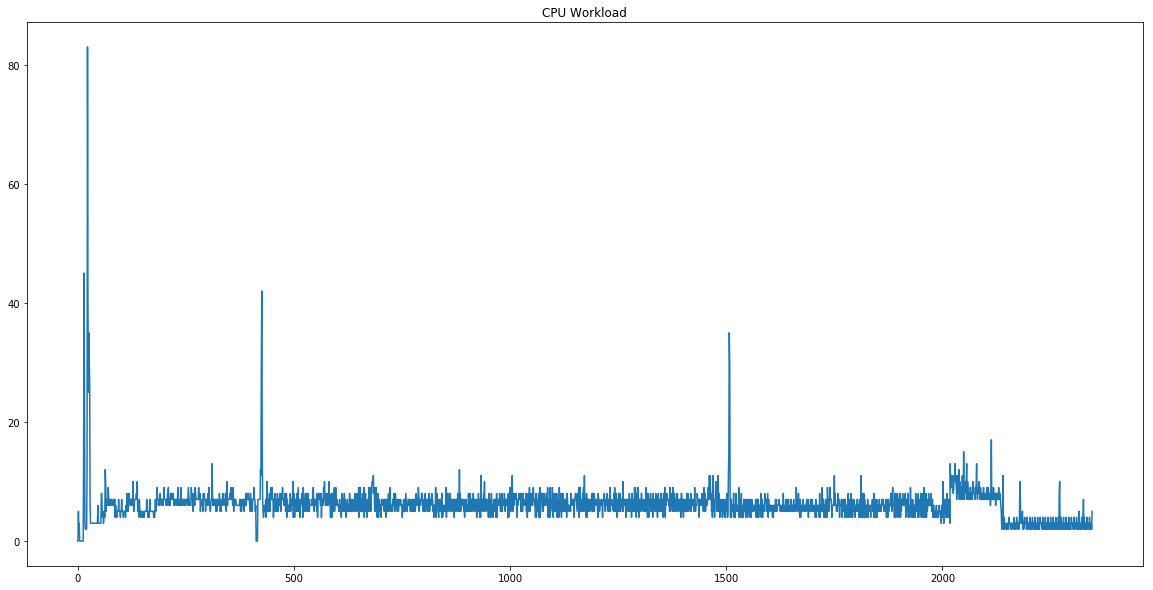

In [3]:
y_1 = torch.tensor(np.loadtxt("cpu_workload.txt", comments="#", delimiter=",", unpack=False))
plt.figure(figsize = (20,10))
plt.plot(np.array(y_1))
plt.title("CPU Workload")

Text(0.5,1,'CPU Waiting Time')

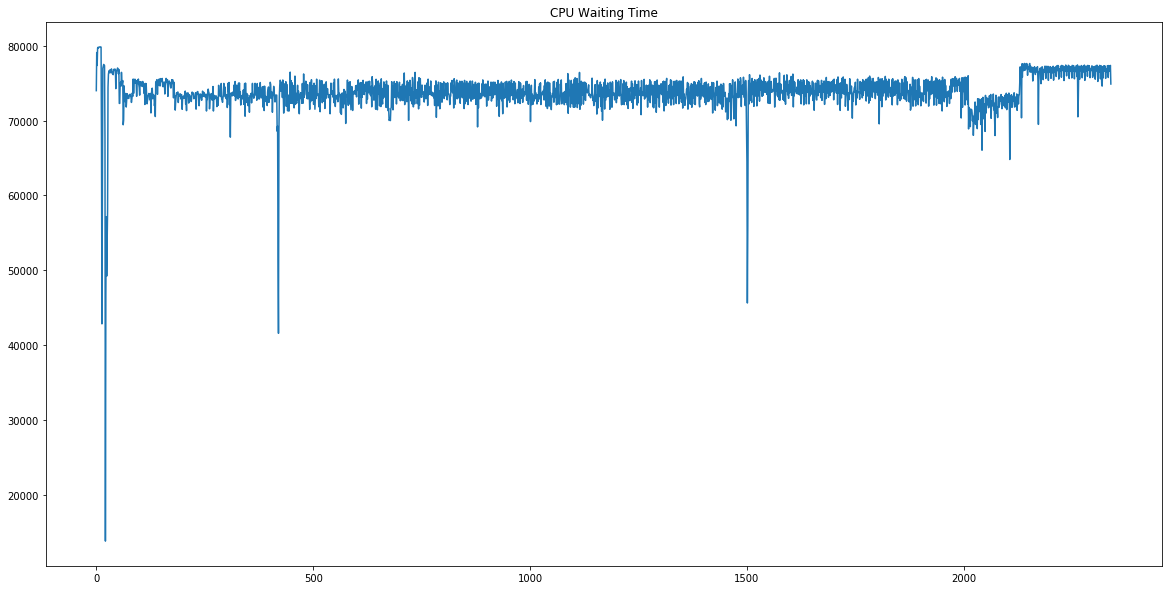

In [4]:
y_2 = torch.tensor(np.loadtxt("cpu_wait.txt", comments="#", delimiter=",", unpack=False))
plt.figure(figsize = (20,10))
plt.plot(np.array(y_2))
plt.title("CPU Waiting Time")

# Initialization

In [5]:
y = y_1

In [6]:
L = y.shape[0]
L_train = int(L*0.8)

S = 7

In [7]:
y_train = y[:L_train]

y_mean = y[:L_train].mean().item()
sigma_sqr = (sum((y_train - y_mean) ** 2) / (L_train - 1)).item()
sigma = sqrt(sigma_sqr)
sigma_e = sigma_u = sigma_v = sigma_w = sigma_r = sigma_o = torch.DoubleTensor([sigma])
print('sigma:     ', sigma)
sigma_evolution = []
sigma_evolution.append(np.array([sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]))

sigma:      3.1911251459489542


In [8]:
a_1 = kalman_filter.gen_a_1(S, y_train)
a_1_evolution = []

p_a = p_c = 1 / L_train

dist_a = dist.Bernoulli(p_a)
dist_c = dist.Bernoulli(p_c)

z_a = dist_a.sample((L_train,))
z_c = dist_c.sample((L_train,))

z_a_evolution = []
z_c_evolution = []
p_a_evolution = []
p_c_evolution = []

p_a_evolution.append(p_a * np.ones(L_train))
p_c_evolution.append(p_c * np.ones(L_train))
z_a_evolution.append(z_a)
z_c_evolution.append(z_c)

In [9]:
t_c_fixed = L_train - 20 - 1
c_fixed = 1.
t_r_fixed = L_train - 20 - 1
r_fixed = 2.

# Inference

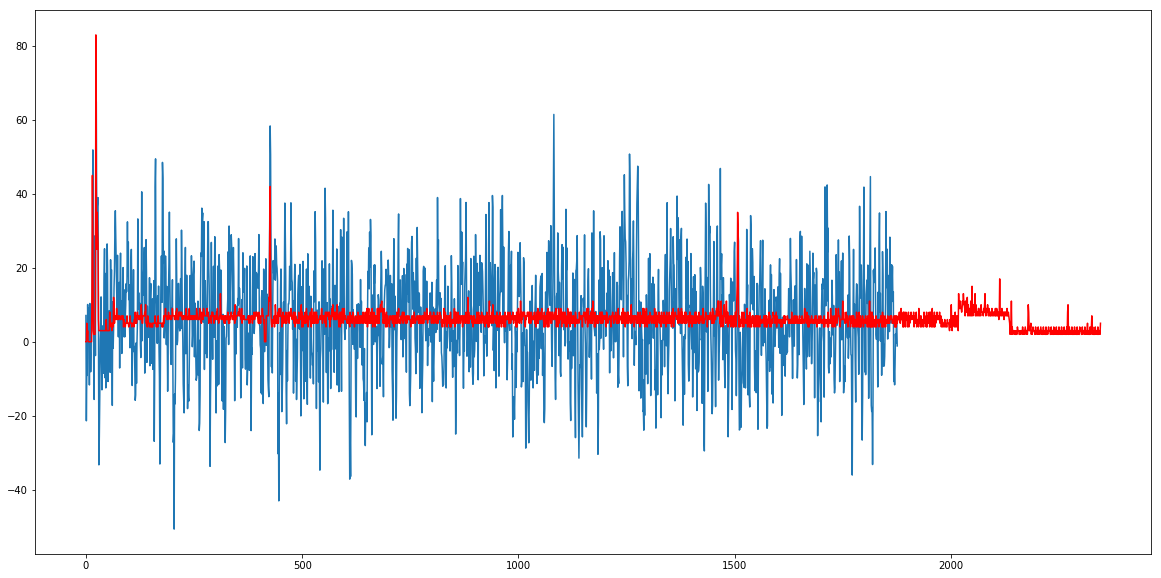

In [11]:
log_L_list = []

log_L_best = - 5 * 10**6
alpha_best = []
z_c_best = []
z_a_best = []



for epoch in range(1000):
    
    
    # 4 Kalman and FPT
    
    d = 1000. #10e7

    P_1 = kalman_filter.gen_P_1(S, d)

    Z_t = kalman_filter.gen_Z_t(S)
    T_t = kalman_filter.gen_T_t(S)
    R_t = kalman_filter.gen_R_t(S)

    H_e = sigma_e ** 2
    H_o = sigma_o ** 2

    Q_eta = kalman_filter.gen_Q_eta(sigma_r, sigma_v, sigma_w)
    Q_xi = kalman_filter.gen_Q_eta(sigma_u, sigma_v, sigma_w)
    
    
    #kalman_filter_using_p
    
    p_a_list = p_a_evolution[-1]
    p_c_list = p_c_evolution[-1]
    
    a_t, P_t, K_t, F_t, v_t = kalman_filter.kalman_filter_using_p(L_train, y_train, a_1, P_1, Z_t, p_a_list, p_c_list, T_t, H_e, H_o, Q_eta, Q_xi, R_t)
    
    #a_t, P_t, K_t, F_t, v_t = kalman_filter.kalman_filter(L_train, y_train, a_1, P_1, Z_t, p_a, p_c, T_t, H_e, H_o, Q_eta, Q_xi, R_t)

    alpha_hat, V  = kalman_smoothing(L_train, v_t, a_t, F_t, K_t, P_t, T_t, Z_t)

    alpha_result = fake_path_trick( alpha_hat, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, p_a, p_c, L, L_train, S, t_c_fixed, c_fixed, t_r_fixed, r_fixed)

    y_result = [a[0].numpy() + a[1].numpy() for a in alpha_result ]
    
    
    if epoch % 10 == 0:
        plt.figure(figsize = (20,10))
        plt.plot(y_result)
        plt.plot(y.numpy(), 'r')
    
    
    
    
    
    #---------------------------------------------------------
    
    # 5 Update z
    
    z_a = [torch.DoubleTensor([0])]
    z_c = [torch.DoubleTensor([0])]
    p_a_new = [torch.DoubleTensor([0])]
    p_c_new = [torch.DoubleTensor([0])]

    for t in range(1,L_train):
        mu_t= alpha_result[t][0]
        y_t = y_train[t]
        gamma_t = alpha_result[t][2]

        mu_t_prev = alpha_result[t-1][0]
        delta_t_prev = alpha_result[t-1][1]

        p_a_t = update_p_a_t(p_a, sigma_o, sigma_e, y_t, mu_t, gamma_t)
        p_c_t = update_p_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev)
    
        
        z_a.append(generate_z_a_t(p_a, sigma_o, sigma_e, y_t, mu_t, gamma_t))
        z_c.append(generate_z_c_t(p_c, sigma_r, sigma_u, mu_t, mu_t_prev, delta_t_prev))
        p_a_new.append(p_a_t)
        p_c_new.append(p_c_t)
        
        
    
    z_a = torch.DoubleTensor(z_a)
    z_c = torch.DoubleTensor(z_c)  
    
    z_c[-1] = 0
    
    p_a_evolution.append(p_a_new)
    p_c_evolution.append(p_c_new)
    z_a_evolution.append(z_a)

    

    
    #---------------------------------------------------------
    
    # 6 Segment control
    
    
    mu = torch.DoubleTensor([a[0] for a in alpha_result])
    l = S

    z_c = segment_control(z_c, mu, sigma_r, l)
    
    z_c_evolution.append(z_c)
    
    
    
    #---------------------------------------------------------
    
    # 7 Update sigma
    
    
    mu = torch.DoubleTensor([a[0] for a in alpha_result])
    gamma  = torch.DoubleTensor([a[2] for a in alpha_result])
    delta  = torch.DoubleTensor([a[1] for a in alpha_result])
    
    delta_with_initial_values = torch.DoubleTensor([alpha_result[0][1]] + [a[1] for a in alpha_result])
    mu_with_initial_values = torch.DoubleTensor([alpha_result[0][0] - alpha_result[0][1]] + [a[0] for a in alpha_result])

    gamma_0_recalculate = []
    for i in range(S-1):
        l = len(gamma_0_recalculate)
        g = -(sum(gamma_0_recalculate) + gamma[:S-1-l].sum())

        gamma_0_recalculate.append(g)

    gamma_0_recalculate.reverse()

    gamma_with_initial_values = torch.DoubleTensor(gamma_0_recalculate + [a[2] for a in alpha_result])


    
    
    
    
    
    sigma_e = update_sigma_e(y_train, mu, gamma, z_a, sigma_e)
    sigma_o = update_sigma_o(y_train, mu, gamma, z_a, sigma_o) 


    sigma_u = update_sigma_u(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_u)
    sigma_r = update_sigma_r(mu,mu_with_initial_values, delta, delta_with_initial_values, z_c, sigma_r)

    sigma_delta = update_sigma_delta(delta, delta_with_initial_values)
    sigma_gamma = update_sigma_gamma(gamma, gamma_with_initial_values, S)
    
    sigma_v = sigma_delta
    sigma_w = sigma_gamma
    
    sigma_evolution.append(np.array([sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]))

    
    
    
    # fake sigma !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #[sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w] = sigma_true
    #sigma_true = [sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w]




    #---------------------------------------------------------

    # 8 Update a_t


    a_1 = torch.zeros(S+1, dtype = torch.float64)
    a_1[:2] = alpha_result[0][:2,0]
    a_1[2:] = alpha_result[S][2:,0]
    a_1 = a_1.view(S+1, -1)
    
    
    a_1_evolution.append(a_1[:,0].numpy())
    
    
    
    
    #---------------------------------------------------------

    # 9 Calculate likelihood
    log_L = log_likelihood(y_train,mu, mu_with_initial_values, gamma, gamma_with_initial_values, delta, delta_with_initial_values, z_a, z_c, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, p_a, p_c, S)

    log_L_list.append(log_L)
    
    if log_L > log_L_best:
        log_L_best = log_L
        alpha_best = alpha_result
        
        z_c_best = z_c
        z_a_best = z_a

# Anomaly Points

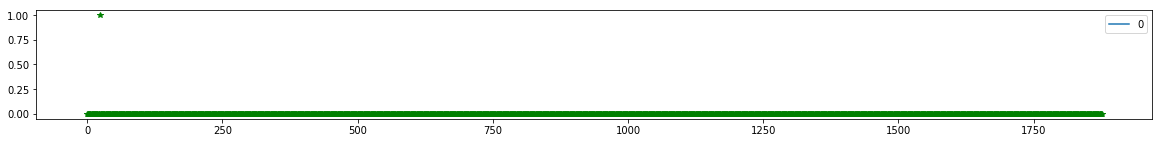

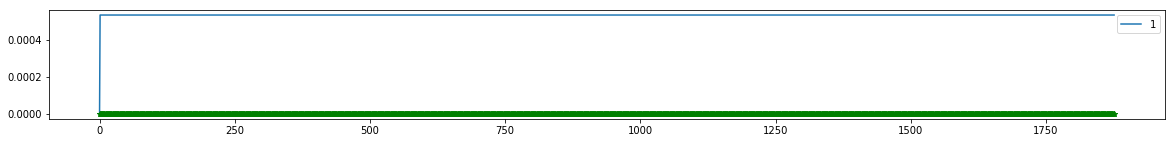

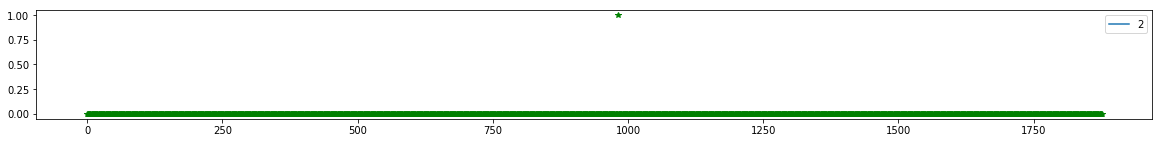

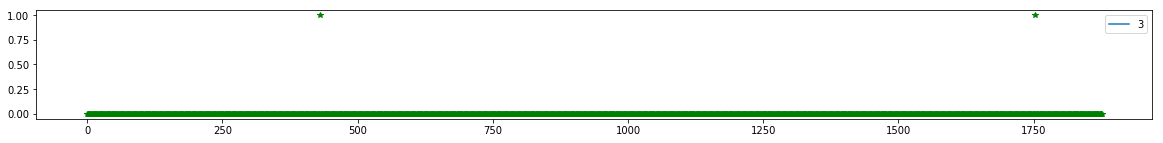

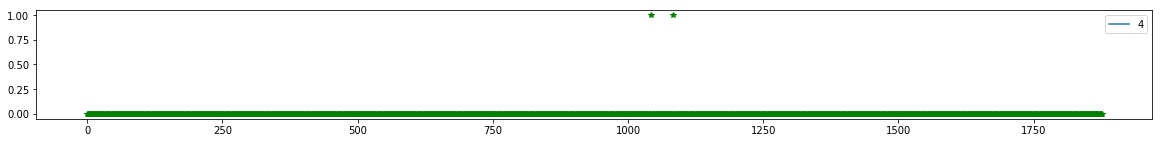

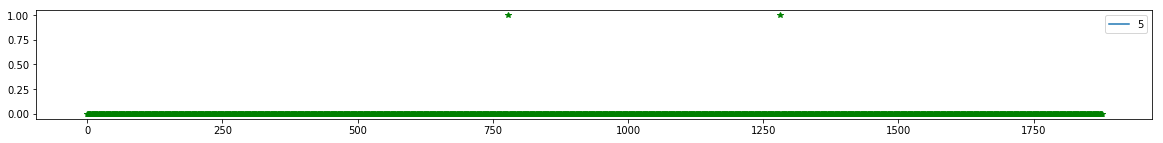

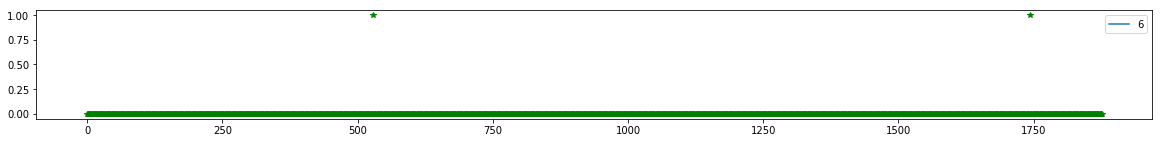

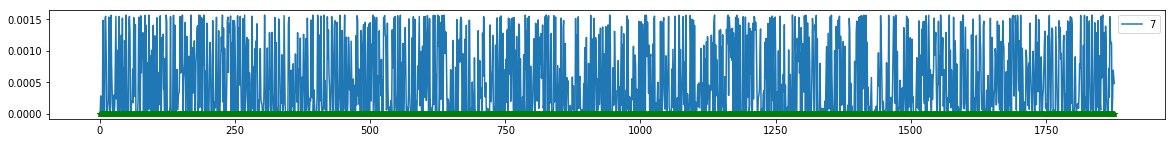

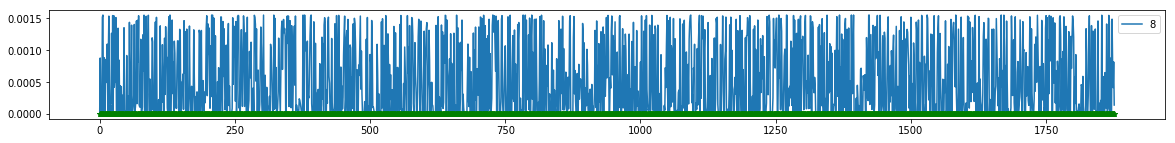

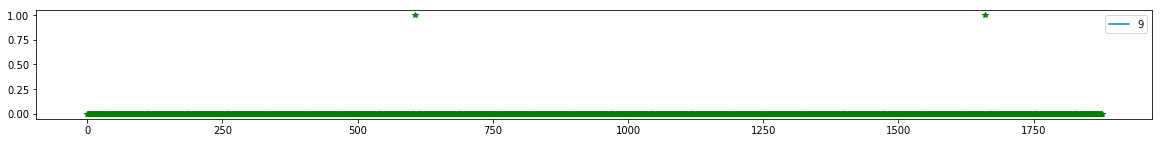

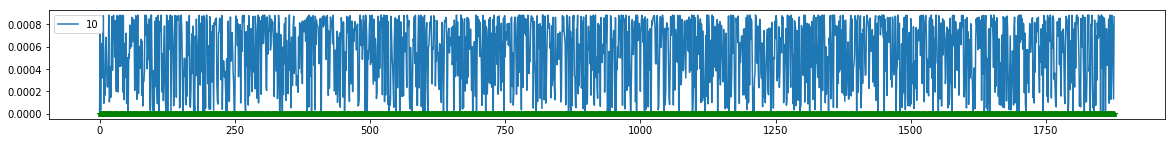

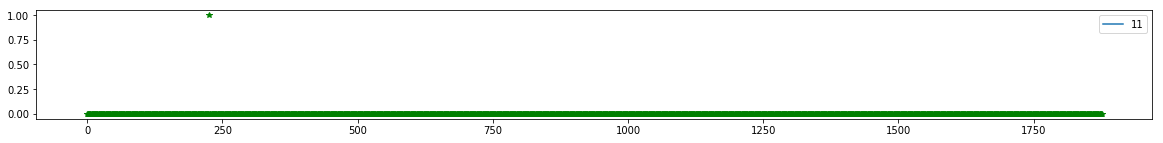

In [12]:
for i in range(0, len(p_a_evolution)):
    plt.figure(figsize = (20,2))
    plt.plot(p_a_evolution[i], label = '{}'.format(i))
    plt.plot(z_a_evolution[i].numpy(), '*g')
    plt.legend()

# Change Points

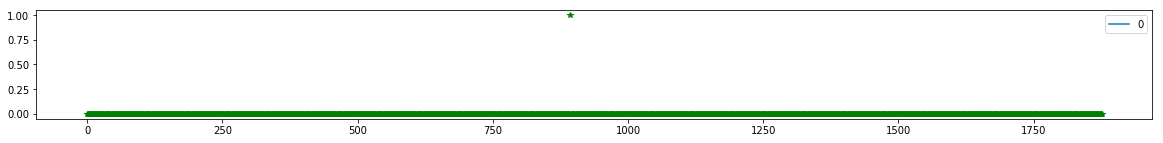

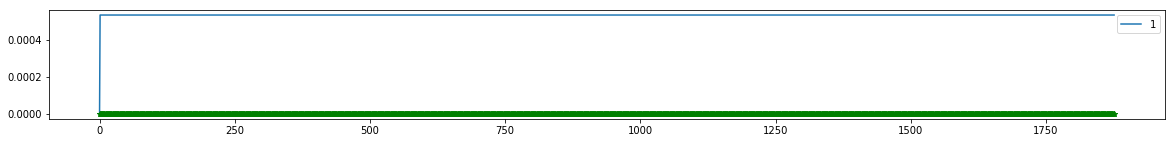

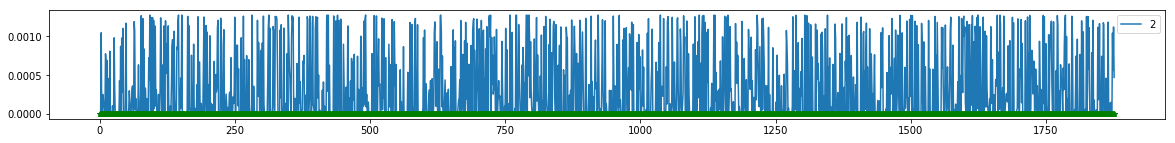

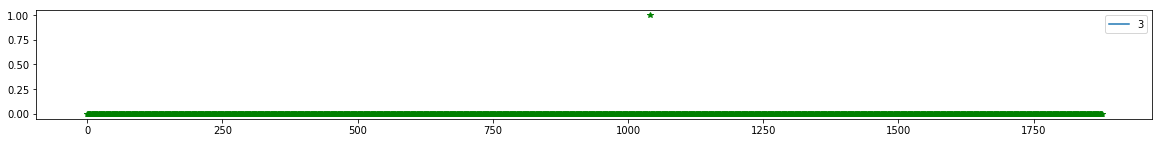

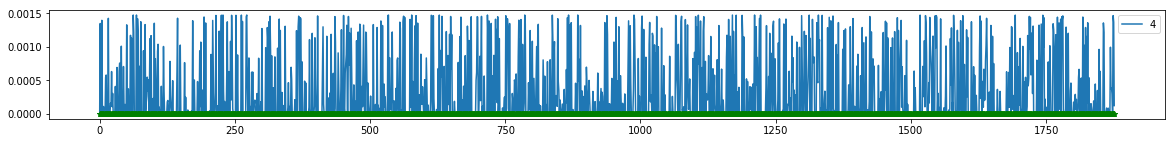

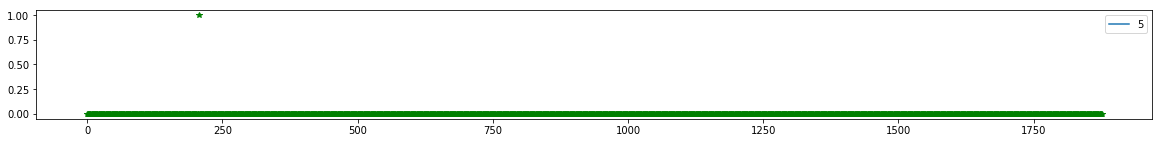

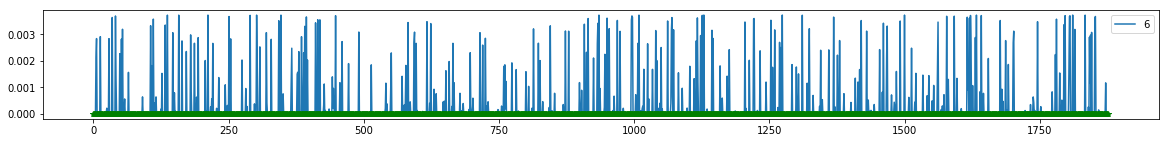

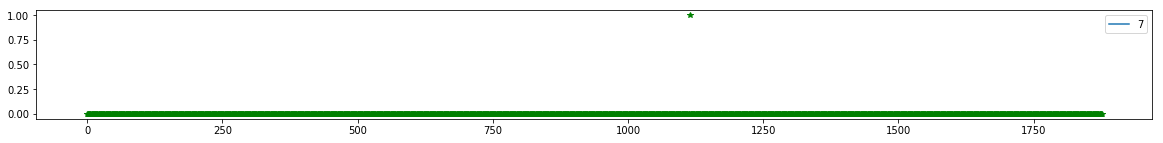

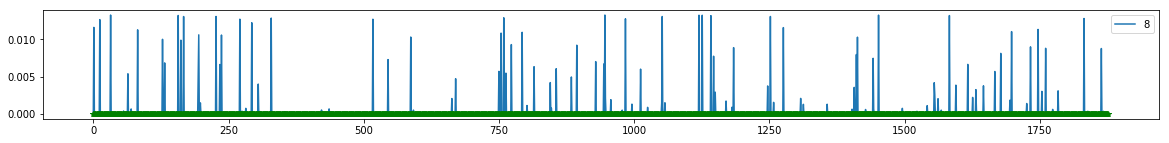

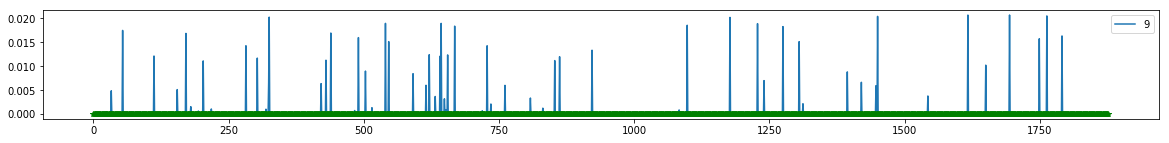

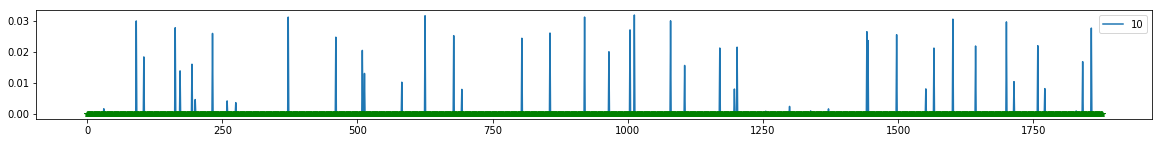

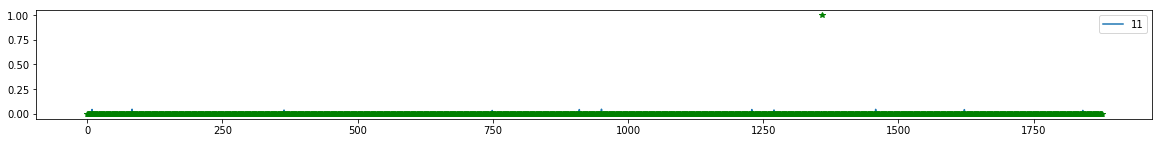

In [13]:
for i in range(0, len(p_a_evolution)):# range( len(p_a_evolution)): #[1, 5, -1]:
    plt.figure(figsize = (20,2))
    plt.plot(p_c_evolution[i], label = '{}'.format(i))
    plt.plot(z_c_evolution[i].numpy(), '*g')
    
    plt.legend()

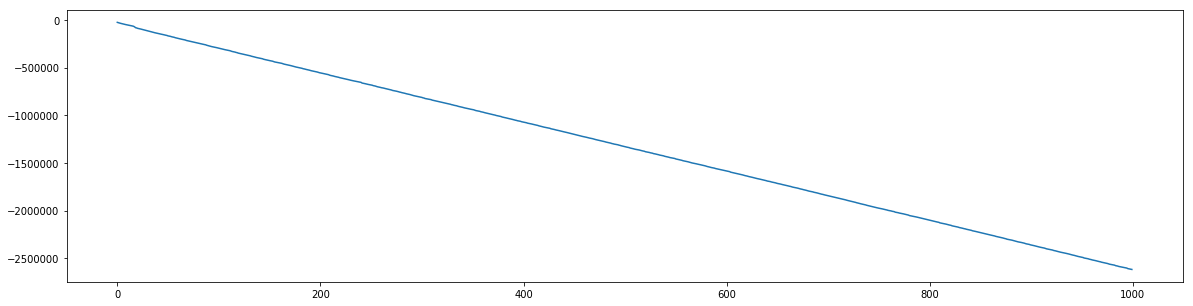

In [15]:
plt.figure(figsize = (20,5))
plt.plot(log_L_list)

# Result

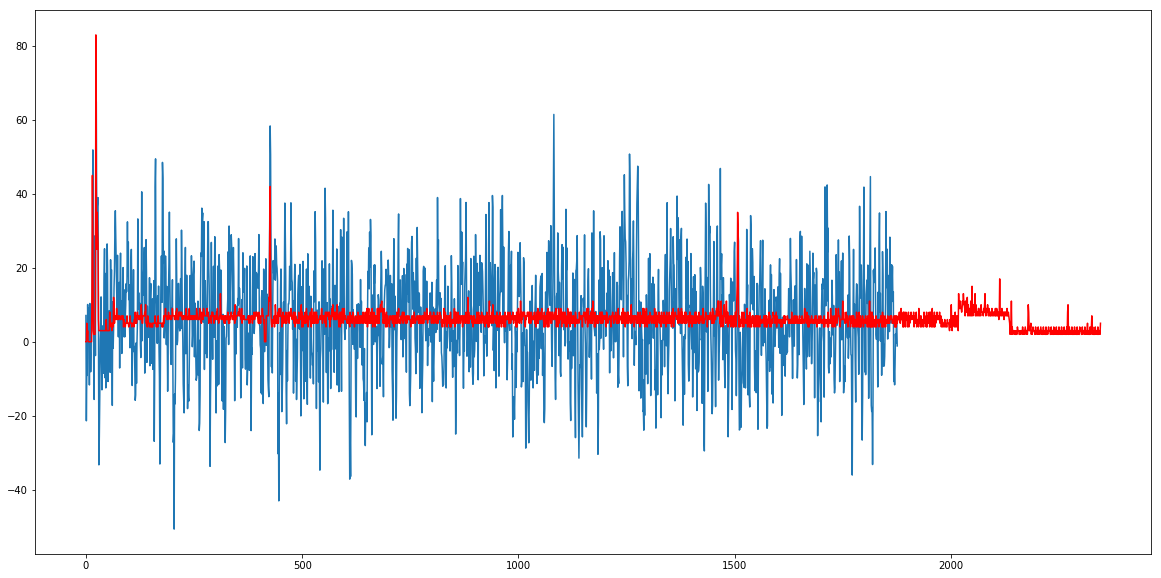

In [14]:
alpha_result = alpha_best

y_result = [a[0].numpy() + a[1].numpy() for a in alpha_result ]

plt.figure(figsize = (20,10))
plt.plot(y_result)
plt.plot(y.numpy(), 'r')

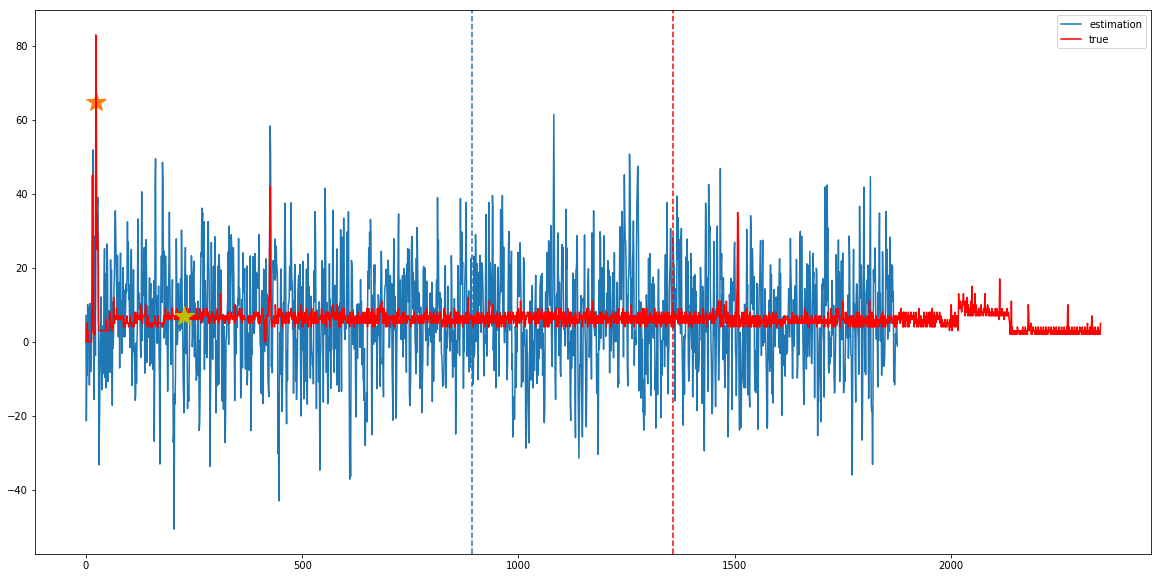

In [70]:
plt.figure(figsize = (20,10))
  
    
y_best = torch.tensor(y_result)[:,0]

plt.plot(np.array(y_result), label = 'estimation')
plt.plot(np.array(torch.nonzero(z_a_best)),np.array(y_best[torch.nonzero(z_a_best)]), '*', markersize=20)
for c in torch.nonzero(z_c_best):
    plt.axvline(x=c, linestyle='--')  
plt.plot(np.array(y), 'r', label = 'true')
plt.plot(np.array(torch.nonzero(z_a)),np.array(y[torch.nonzero(z_a)]), '*y', markersize=20)
for c in torch.nonzero(z_c):
    plt.axvline(x=c, linestyle='--', color='r')  
    
plt.legend()

# Forecasting

In [23]:
mu_0 = alpha_best[-1][0].numpy()
delta_0 = alpha_best[-1][1].numpy()
gamma_0 = alpha_best[-1][2:].numpy()


y_all = []
for i in range(100):
    y_f = generative_procedure_future(mu_0, delta_0, gamma_0, sigma_e, sigma_o, sigma_u, sigma_r, sigma_v, sigma_w, L - L_train, S)

    y_all.append(y_f.numpy())



In [24]:
y_all = np.array(y_all)

for t in range(y_all.shape[1]):
    y_all.sort(axis = 0)
    
y_average = y_all.mean(axis = 0)
y_low = y_all[5,:]
y_high = y_all[95,:]

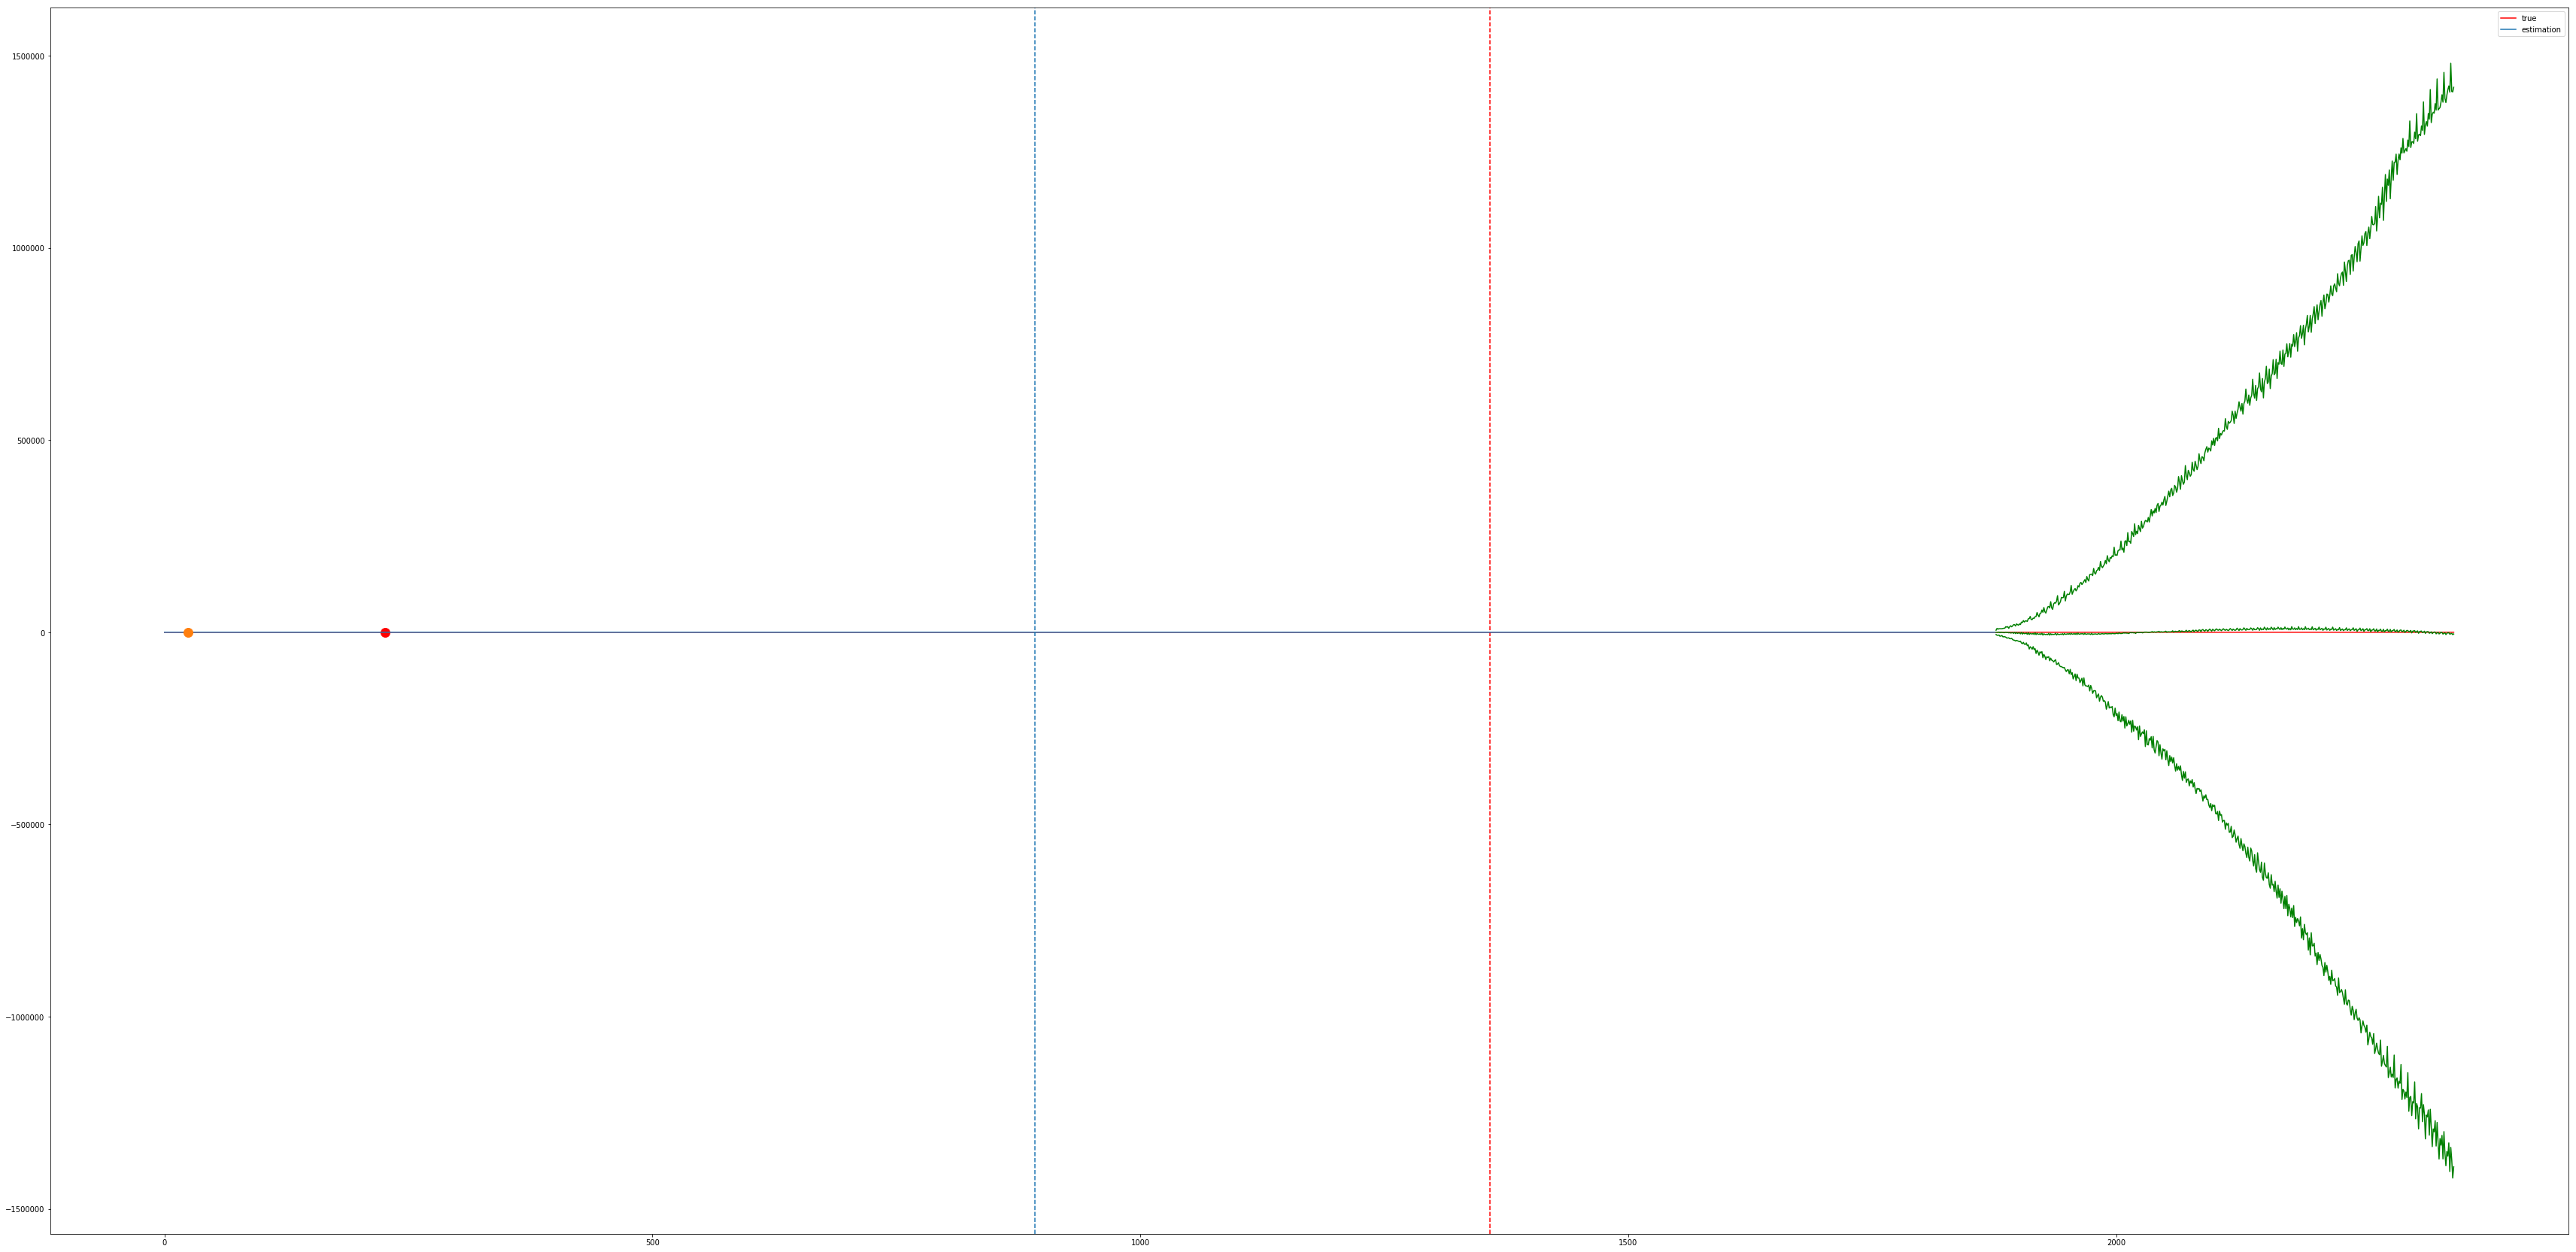

In [71]:
plt.figure(figsize = (60,30))
plt.plot(np.array(y), 'r', label = 'true')
plt.plot(np.array(torch.nonzero(z_a)),np.array(y[torch.nonzero(z_a)]), 'or', markersize=12)
for c in torch.nonzero(z_c):
    plt.axvline(x=c, linestyle='--', color='r')    
    
y_best = torch.tensor(y_result)[:,0]

plt.plot(np.array(y_result), label = 'estimation')
plt.plot(np.array(torch.nonzero(z_a_best)),np.array(y_best[torch.nonzero(z_a_best)]), 'o', markersize=12)
for c in torch.nonzero(z_c_best):
    plt.axvline(x=c, linestyle='--')    
    
    
plt.plot(np.arange(L_train, L), y_average, 'g')
plt.plot(np.arange(L_train, L), y_low, 'g')
plt.plot(np.arange(L_train, L), y_high, 'g')
plt.legend()

In [72]:
(sum(y_average - y[L_train:].numpy())**2 / (L - L_train)) ** 0.5

50116.29607986499